# Support information

There are three parts in this support information:
    - Example to use NN_ensemble_relaxer for molecule geomoetry optimization
    - Figures for configurations used as the example in the manuscript
    - Code to access the datasets for reproducing the main figures in the manuscript

## Example of NN_ensemble_relaxer utilization

### Installation

We first download the NN_ensemble_relaxer repo from the github and compile the required file. The module to calculate the symmetry function is modified based on the functions from SympleNN <sup>1</sup>.

<code> git clone https://github.com/yilinyang1/NN_ensemble_relaxer.git </code>  
<code> cd utils  </code>  
<code> python libsymf_builder  </code>  

### Instantiate NN_ensemble_relaxer and run the relaxation
Assume we have a ASE database called db contains the configurations need to be optimized, we could just feed it into the NN_ensemble_relaxer to conduct the relaxation.

```python
from nn_optimize import Ensemble_Relaxer

nn_params = {'layer_nodes': [40, 40], 'activations': ['tanh', 'tanh'], 'lr': 1}  # NN hyperparameters
alpha = 2.0  # confidence coeffience used to control in what extend we trust the NN model

# feed ASE database db, set groud truth calculator, specify the folder name to store intermediate models and data
relaxer = Ensemble_Relaxer(db=db, calculator=EMT(), jobname='AuPd-nano-test', ensemble_size=10, 
                           alpha=alpha, nn_params=nn_params)

# relaxer.run() returns a ase-db containing relaxed configurations
relaxed_db = relaxer.run(fmax=0.05, steps=50)
```

Above is a basic example, more details could be found in the github repo.

## Figures for configurations used as the example in the manuscript
In second part of the result section, we use 13 Acrolein/AgPd configurations as the example to show the advantage of multiple configurations during geometry optimization. Here, we provides the figures for these 13 configurations.

In [1]:
from ase.db import connect
from ase.io import write
from ase.visualize import view
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

data_path = './Acrolein-AgPd-single-multiple-configs/initial-configs.db'
db = connect(data_path)
i = 1
for entry in db.select():
    write(f'./Acrolein-AgPd-single-multiple-configs/images/image-{i}.png', entry.toatoms())
    i += 1

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i in range(15):
    row, col = i // 5, i % 5
    if i < 13:
        tmp_image = mpimg.imread(f'./Acrolein-AgPd-single-multiple-configs/images/image-{i+1}.png')
        axes[row][col].imshow(tmp_image)
        axes[row][col].set_title(f'config-{i+1}')
    axes[row][col].axis('off')
fig.tight_layout()

## Code to access the datasets for reproducing the main figures in the manuscript

### Acceleration of the geometry optimiztion for Acrolein/AgPd

In [ ]:
from ase.io.trajectory import Trajectory
import numpy as np

single_steps = []
multi_steps = []
warm_steps = []

for i in range(13):
    single_traj = Trajectory(f'./Acrolein-AgPd-single-multiple-configs/single-config-scratch-trajs/config-{i+1}.traj')
    single_steps.append(len(single_traj))
    multi_traj = Trajectory(f'./Acrolein-AgPd-single-multiple-configs/multi-config-scratch-trajs/config-{i+1}.traj')
    multi_steps.append(len(multi_traj))
    warm_traj = Trajectory(f'./Acrolein-AgPd-single-multiple-configs/multi-config-warmup-trajs/config-{i+1}.traj')
    warm_steps.append(len(warm_traj))

steps = [single_steps, multi_steps, warm_steps]
labels = ['single', 'multiple', 'warm up']
mean_labels = ['single mean', 'multiple mean', 'warm up mean']
xs = range(1, 14)


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(xs, steps[i], '-o', label = labels[i])
    means = [round(np.mean(steps[i]), 1)] * len(xs)
    ax.plot(xs, means, '--', color=f'C{i}', label = mean_labels[i])
    ax.text(1, means[0] + 0.4, str(means[0]))

ax.legend(bbox_to_anchor=(0.31, 0.75), ncol=2)
ax.set_xticks(range(1, 14))
ax.set_yticks(range(6, 25, 2))
ax.set_xlabel('configuration')
ax.set_ylabel('# of DFT calls')
fig.savefig('./single-multi-warmup.png', dpi=300)

### Performance for various systems

In [ ]:
from matplotlib import pyplot as plt
import pickle
import numpy as np

path = 'more-geometry-optimization-data'

with open(f'./{path}/AuPd-slab-vasp-data-25.pkl', 'rb') as f:
    slab_vasp_data = pickle.load(f)

with open(f'./{path}/AuPd-slab-nn-data-25.pkl', 'rb') as f:
    slab_nn_data = pickle.load(f)

with open(f'./{path}/Acrolein-AgPd-vasp-data-100.pkl', 'rb') as f:
    ads_vasp_data = pickle.load(f)

with open(f'./{path}/Acrolein-AgPd-nn-data-scratch-100.pkl', 'rb') as f:
    ads_nn_data = pickle.load(f)

with open(f'./{path}/CO-AuPd-Ico-vasp-data-10.pkl', 'rb') as f:
    nano_vasp_data = pickle.load(f)

with open(f'./{path}/CO-AuPd-Ico-nn-data-10.pkl', 'rb') as f:
    nano_nn_data = pickle.load(f)

ads_nn_step_mean = np.mean(ads_nn_data['steps'])
ads_vasp_step_mean = np.mean(ads_vasp_data['steps'])

slab_nn_step_mean = np.mean(slab_nn_data['steps'])
slab_vasp_step_mean = np.mean(slab_vasp_data['steps'])

nano_nn_step_mean = np.mean(nano_nn_data['steps'])
nano_vasp_step_mean = np.mean(nano_vasp_data['steps'])

step_mean = np.array([slab_nn_step_mean, slab_vasp_step_mean, nano_nn_step_mean, 
                      nano_vasp_step_mean, ads_nn_step_mean, ads_vasp_step_mean])

nn_steps = step_mean[[0, 2, 4]]
vasp_steps = step_mean[[1, 3, 5]]
nn_xs = [1, 2.5, 4]
vasp_xs = [1.5, 3, 4.5]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.bar(nn_xs, nn_steps, width=0.5, label='NN AL')
ax.bar(vasp_xs, vasp_steps, width=0.5, label='VASP QN')
ax.set_ylabel('DFT calls')
ax.set_yticks(range(0, 160, 20))
ax.set_xticks([1.25, 2.75, 4.25])
ax.set_xticklabels(['AuPd FCC111', 'CO/AuPd Icosahedron', 'Acrolein/AgPd FCC111'])
ax.legend(loc='upper left')
ax.text(0.95, 7.5, str(nn_steps[0]))
ax.text(1.35, vasp_steps[0] + 1.1, str(vasp_steps[0]))
ax.text(2.4, nn_steps[1] + 1.1, str(nn_steps[1]))
ax.text(2.9, vasp_steps[1] + 1.1, str(vasp_steps[1]))
ax.text(3.85, nn_steps[2] + 1.1, str(nn_steps[2]))
ax.text(4.3, vasp_steps[2] + 1.1, str(vasp_steps[2]))
fig.savefig('./slab-nano-ads.png', dpi=300)

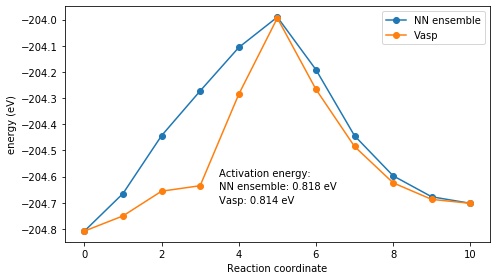

In [6]:
from ase.db import connect
from matplotlib import pyplot as plt

init_db = connect('./Acetylele-hydrogenation-NEB/Acetylene-hydro-initial-configs.db')
vasp_db = connect('./Acetylele-hydrogenation-NEB/Acetylenen-hydro-vasp-cnvg.db')
nn_db = connect('./Acetylele-hydrogenation-NEB/Acetylene-hydro-nn-cnvg.db')

init_nrgs = [entry.energy for entry in init_db.select()]
vasp_nrgs = [entry.energy for entry in vasp_db.select()]
nn_nrgs = [entry.energy for entry in nn_db.select()]
xs = range(len(vasp_nrgs))

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
ax.plot(xs, nn_nrgs, '-o')
ax.plot(xs, vasp_nrgs, '-o')
ax.set_xlabel('Reaction coordinate')
ax.set_ylabel('energy (eV)')
ax.legend(['NN ensemble', 'Vasp'])
vasp_act = vasp_nrgs[5] - vasp_nrgs[0]
nn_act = nn_nrgs[5] - nn_nrgs[0]
ax.text(3.5, -204.6, 'Activation energy:')
ax.text(3.5, -204.65, f'NN ensemble: {round(nn_act, 3)} eV')
ax.text(3.5, -204.7, f'Vasp: {round(vasp_act, 3)} eV')
fig.tight_layout()
fig.savefig('./acetylene.png', dpi=300)

### Reference

[1] Kyuhyun Lee et al. “SIMPLE-NN: An efficient package for training and executing neural-network interatomic potentials”. In:Computer Physics Communications242 (2019), pp. 95–103. https://doi.org/10.1016/j.cpc.2019.04.014